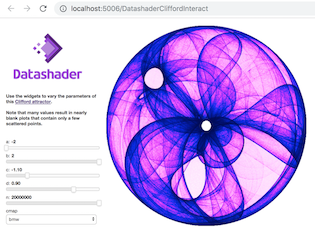

# Clifford attractors with Datashader, Panel, and interact

[Clifford attractors](https://anaconda.org/jbednar/clifford_attractor/notebook) are a type of iterative equation that traces the path of a particle through a 2D space using functions of sine and cosine terms that make interesting "attractor" patterns (covering only some portions of the possible space, in certain shapes). 

Here we use Numpy and Pandas to calculate a dataframe consisting of millions of such locations, using [Numba](numba.pydata.org) to make generating them 50X faster than bare Python. We'll then plot the results as a static image using [Datashader](http://datashader.org), which renders arbitrarily large data into fixed-sized images.  

If you can have a live Python process running (not just a static webpage or anaconda.org notebook viewer), we'll also show you how to make an interactive app for exploring parameter values, and a standalone dashboard suitable for sharing widely. Before you run the notebook or server, you'll need to set up a [conda](http://conda.pydata.org/miniconda.html) environment and run `conda install -c pyviz datashader panel`.

In [1]:
import numpy as np, pandas as pd
from numba import jit

@jit
def clifford_trajectory(a, b, c, d, x0, y0, n):
    xs, ys = np.zeros(n), np.zeros(n)
    xs[0], ys[0] = x0, y0
    for i in np.arange(n-1):
        xs[i+1] = np.sin(a * ys[i]) + c * np.cos(a * xs[i])
        ys[i+1] = np.sin(b * xs[i]) + d * np.cos(b * ys[i])
    return pd.DataFrame(dict(x=xs,y=ys))

We can visualize the resulting dataframe using [Datashader](http://datashader.org), with colormaps from [Colorcet](http://colorcet.pyviz.org):

In [2]:
import datashader as ds
from datashader import transfer_functions as tf

from colorcet import palette_n
ps ={k:p[::-1] for k,p in palette_n.items()}

import panel as pn
pn.extension()

def clifford_plot(a=1.9, b=1.9, c=1.9, d=0.8, n=1000000, colormap=ps['kbc']):
    cvs = ds.Canvas(plot_width=600, plot_height=600)
    agg = cvs.points(clifford_trajectory(a, b, c, d, 0, 0, n), 'x', 'y')
    return tf.shade(agg, cmap=colormap)

<ipython-input-1-d6b918a5ad5b>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "clifford_trajectory" failed type inference due to: Unknown attribute 'DataFrame' of type Module(<module 'pandas' from '/Users/brey/miniconda3/envs/pyPoseidon/lib/python3.8/site-packages/pandas/__init__.py'>)

File "<ipython-input-1-d6b918a5ad5b>", line 11:
def clifford_trajectory(a, b, c, d, x0, y0, n):
    <source elided>
        ys[i+1] = np.sin(b * xs[i]) + d * np.cos(b * ys[i])
    return pd.DataFrame(dict(x=xs,y=ys))
    ^

During: typing of get attribute at <ipython-input-1-d6b918a5ad5b> (11)

File "<ipython-input-1-d6b918a5ad5b>", line 11:
def clifford_trajectory(a, b, c, d, x0, y0, n):
    <source elided>
        ys[i+1] = np.sin(b * xs[i]) + d * np.cos(b * ys[i])
    return pd.DataFrame(dict(x=xs,y=ys))
    ^

  @jit
<ipython-input-1-d6b918a5ad5b>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because F

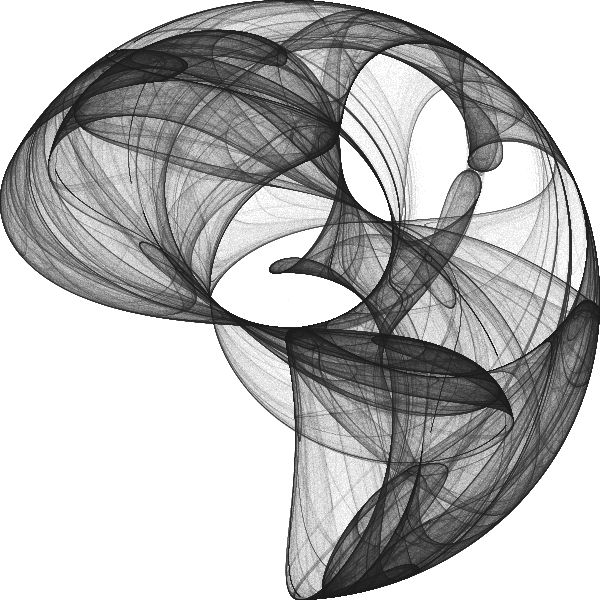

In [3]:
clifford_plot(a=1.7, b=1.7, c=0.6, d=1.2, n=20000000, colormap=ps['dimgray'])

Twenty million data points from an attractor clearly makes an interesting shape! The shapes depend on the parameters provided, and we can now easily build a control panel for exploring the effect of those parameters, using interactive widgets from [Panel](http://panel.pyviz.org):

Column
    [0] Column
        [0] FloatSlider(end=5.699999999999999, name='a', start=-1.9, value=1.9, value_throttled=1.9)
        [1] FloatSlider(end=5.699999999999999, name='b', start=-1.9, value=1.9, value_throttled=1.9)
        [2] FloatSlider(end=5.699999999999999, name='c', start=-1.9, value=1.9, value_throttled=1.9)
        [3] FloatSlider(end=2.4000000000000004, name='d', start=-0.8, value=0.8, value_throttled=0.8)
        [4] IntSlider(end=20000000, name='n', start=1, value=1000000, value_throttled=10000000)
        [5] Select(name='colormap', options={'bgy': ['#fff123', ...}, value=['#b3fef5', '#b0fef5', ...])
    [1] Row
        [0] PNG(Image, name='interactive00007')
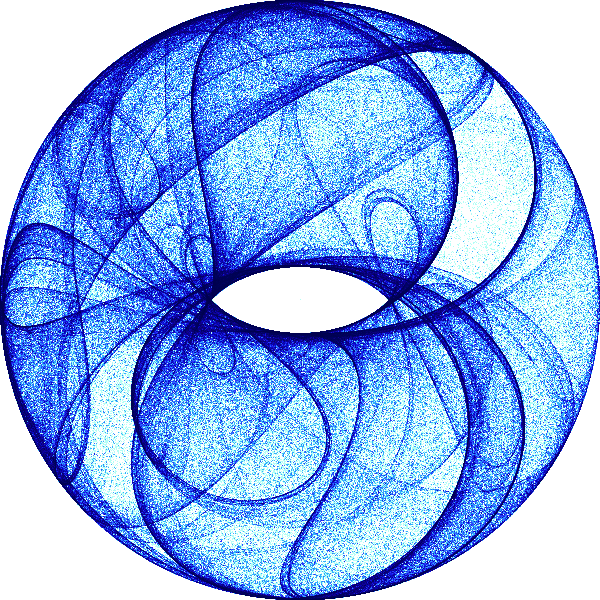

In [4]:
pn.interact(clifford_plot, n=(1,20000000), colormap=ps)

Here `interact()` returns an object that lets us vary the arguments to the given function interactively and see the results, as long as this notebook is backed by a live, running Python process.  

`interact()` is great for quick exploration, but it's not a dead end -- what it returns is actually a reusable, compositional `Panel` object, and we can use its components to build a more customized dashboard if we like.  Let's define an object `i` to capture the result of `interact`, and see what we've got:

In [5]:
i = pn.interact(clifford_plot, a=(0,2), b=(0,2), c=(0,2), d=(0,2), 
                n=(1,20000000), colormap=ps, panel_layout=pn.Row)
print(i)

Column
    [0] Column
        [0] FloatSlider(end=2, name='a', value=1.9, value_throttled=1)
        [1] FloatSlider(end=2, name='b', value=1.9, value_throttled=1)
        [2] FloatSlider(end=2, name='c', value=1.9, value_throttled=1)
        [3] FloatSlider(end=2, name='d', value=0.8, value_throttled=1)
        [4] IntSlider(end=20000000, name='n', start=1, value=1000000, value_throttled=10000000)
        [5] Select(name='colormap', options={'bgy': ['#fff123', ...}, value=['#b3fef5', '#b0fef5', ...])
    [1] Row
        [0] PNG(Image, name='interactive00022')


As you can see, the resulting object is a `pn.Column` of two items: a `pn.WidgetBox` at index 0 and `pn.interactive` object at index 1.  We can now mix and match these components into any dashboard configuration we like. For instance, if the only widget we wanted was for the colormap, we could make a special-purpose app just for that using `pn.Column(i[0][5], i[1])` (returning a column with just the "Select" widget above the image output). 

Here let's remix these components into a new app that can be served as a standalone dashboard.  We'll put the widgets into a column with a logo image and some Markdown text to explain how to use the dashboard, and put that column into a row with the image output:

In [6]:
logo = "https://tinyurl.com/y9c2zn65/logo_stacked_s.png"

text = pn.panel("#### Use the widgets to vary the parameters of this "
                "[Clifford attractor](https://anaconda.org/jbednar/clifford_attractor).\n\n"
                "#### Note that many values result in nearly "
                "blank plots that contain only a few scattered points.", 
                width=310, height=100)

pn.Row(pn.Column(logo, text, i[0]), i[1]).servable();

We could have displayed the new object here in the notebook by removing the semicolon at the end of the cell, but this expanded dashboard version isn't actually that useful in a notebook, where we already have ways of showing logos and text. Instead, the expanded version is meant for launching as a standalone server outside of the notebook, and so we've marked that object `.servable()` to declare that if someone later runs this notebook as a server process (using `panel serve --show CliffordInteract.ipynb`), your browser will open a separate window with the serveable object ready to explore or share, just like the screenshot at the top of this notebook. So it's your choice -- use a static Image in a Jupyter cell, make it an interactive app using Panel's `interact`, or very easily reconfigure it into a shareable, deployable dashboard!

In [ ]:
#! panel serve --show --port 5009 clifford.ipynb